## Import Libraries

As usual, before we begin any analysis and modeling, let's import several necessary libraries to work with the data.

In [ ]:
import os
# Data Analysis
import pandas as pd
import numpy as np
import keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Neural Network Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report

## Load the Images

Here is the structure of our folder containing image data:


```
card_data
├───test
│   ├───bad
│   └───ok
└───train
    ├───bad
    └───ok
```

The folder `card_data` consists of two subfolders `test` and `train` in which each of them has another subfolder: `bad` and `ok` denoting the class of our target variable. The images inside `train` will be used for model fitting and validation, while `test` will be used purely for testing the model performance on unseen images.

## Data Augmentation

We apply on-the-fly data augmentation, a technique to expand the training dataset size by creating a modified version of the original image which can improve model performance and the ability to generalize. We will use with the following parameters:

- `rotation_range`: Degree range for random rotations. We choose 360 degrees since the product is a round object.
- `width_shift_range`: Fraction range of the total width to be shifted.
- `height_shift_range`: Fraction range of the total height to be shifted.
- `shear_range`: Degree range for random shear in a counter-clockwise direction.
- `zoom_range`: Fraction range for random zoom.
- `horizontal_flip` and `vertical_flip` are set to True for randomly flip image horizontally and vertically.
- `brightness_range`: Fraction range for picking a brightness shift value.

Other parameters:

- `rescale`: Eescale the pixel values to be in range 0 and 1.
- `validation_split`: Reserve 15% of the training data for validation, and the rest 85% for model fitting.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_generator = ImageDataGenerator(rotation_range = 90,
                                     width_shift_range = 0.05,
                                     height_shift_range = 0.05,
                                     shear_range = 0.05,
                                     zoom_range = 0.05,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range = [0.75, 1.25],
                                     rescale = 1./255,
                                     validation_split = 0.2)

We define another set of value for the `flow_from_directory` parameters:

- `IMAGE_DIR`: The directory where the image data is stored.
- `IMAGE_SIZE`: The dimension of the image (300 px by 300 px).
- `BATCH_SIZE`: Number of images that will be loaded and trained at one time.
- `SEED_NUMBER`: Ensure reproducibility.
- `color_mode = "grayscale"`: Treat our image with only one channel color.
- `class_mode` and `classes` define the target class of our problem. In this case, we denote the `bad` class as positive (1), and `ok` as a negative class.
- `shuffle` = True to make sure the model learns the bad and ok images alternately.

In [ ]:
IMAGE_DIR = '../content/drive/MyDrive/data/card_data/' 
IMAGE_SIZE = (300, 300)
BATCH_SIZE = 64
SEED_NUMBER = 123

gen_args = dict(target_size = IMAGE_SIZE,
                color_mode = "grayscale",
                batch_size = BATCH_SIZE,
                class_mode = "binary",
                classes = {"ok": 0, "bad": 1},
                seed = SEED_NUMBER)

train_dataset = train_generator.flow_from_directory(
                                        directory = IMAGE_DIR + "train",
                                        subset = "training", shuffle = True, **gen_args)
validation_dataset = train_generator.flow_from_directory(
                                        directory = IMAGE_DIR + "train",
                                        subset = "validation", shuffle = True, **gen_args)

Found 596 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


We will not perform any data augmentation on the test data.

In [ ]:
test_generator = ImageDataGenerator(rescale = 1./255)
test_dataset = test_generator.flow_from_directory(directory = IMAGE_DIR + "test",
                                                  shuffle = False,
                                                  **gen_args)

Found 186 images belonging to 2 classes.


## Visualize the Image

We successfully load and apply on-the-fly data augmentation according to the specified parameters. Now, in this section, we visualize the image to make sure that it is loaded correctly.

### Visualize Image in Batch
Visualize the first batch (`BATCH_SIZE = 64`) of the training dataset (images with data augmentation) and also the test dataset (images without data augmentation).

In [ ]:
mapping_class = {0: "ok", 1: "bad"}
mapping_class

{0: 'ok', 1: 'bad'}

In [ ]:
def visualizeImageBatch(dataset, title):
    images, labels = next(iter(dataset))
    images = images.reshape(BATCH_SIZE, *IMAGE_SIZE)
    fig, axes = plt.subplots(8, 8, figsize=(16,16))

    for ax, img, label in zip(axes.flat, images, labels):
        ax.imshow(img, cmap = "gray")
        ax.axis("off")
        ax.set_title(mapping_class[label], size = 20)

    plt.tight_layout()
    fig.suptitle(title, size = 30, y = 1.05, fontweight = "bold")
    plt.show()
    
    return images

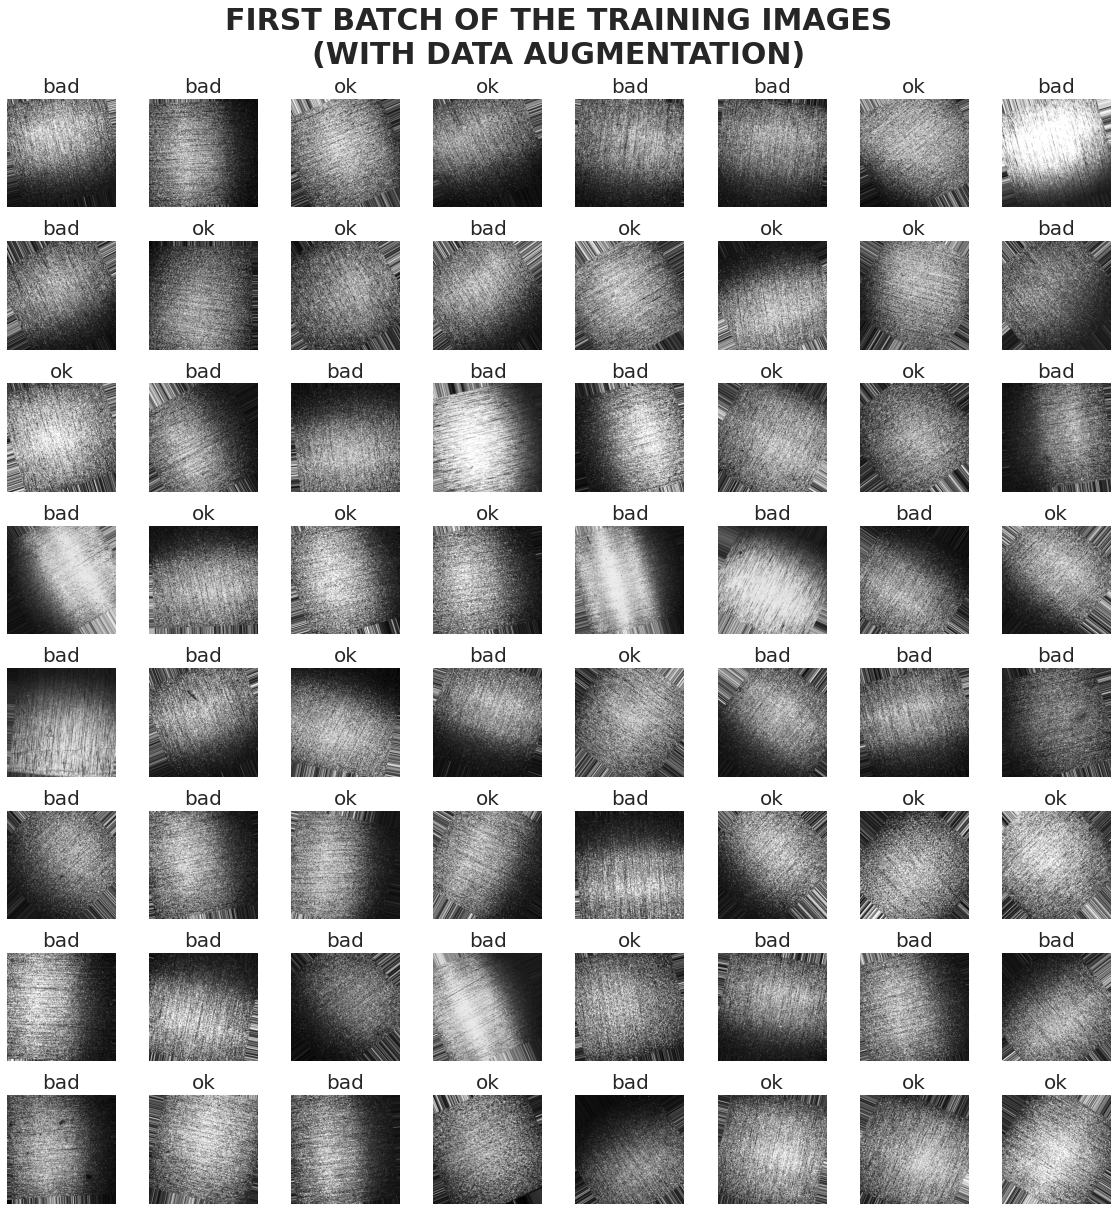

In [ ]:
train_images = visualizeImageBatch(train_dataset,
                                   "FIRST BATCH OF THE TRAINING IMAGES\n(WITH DATA AUGMENTATION)")

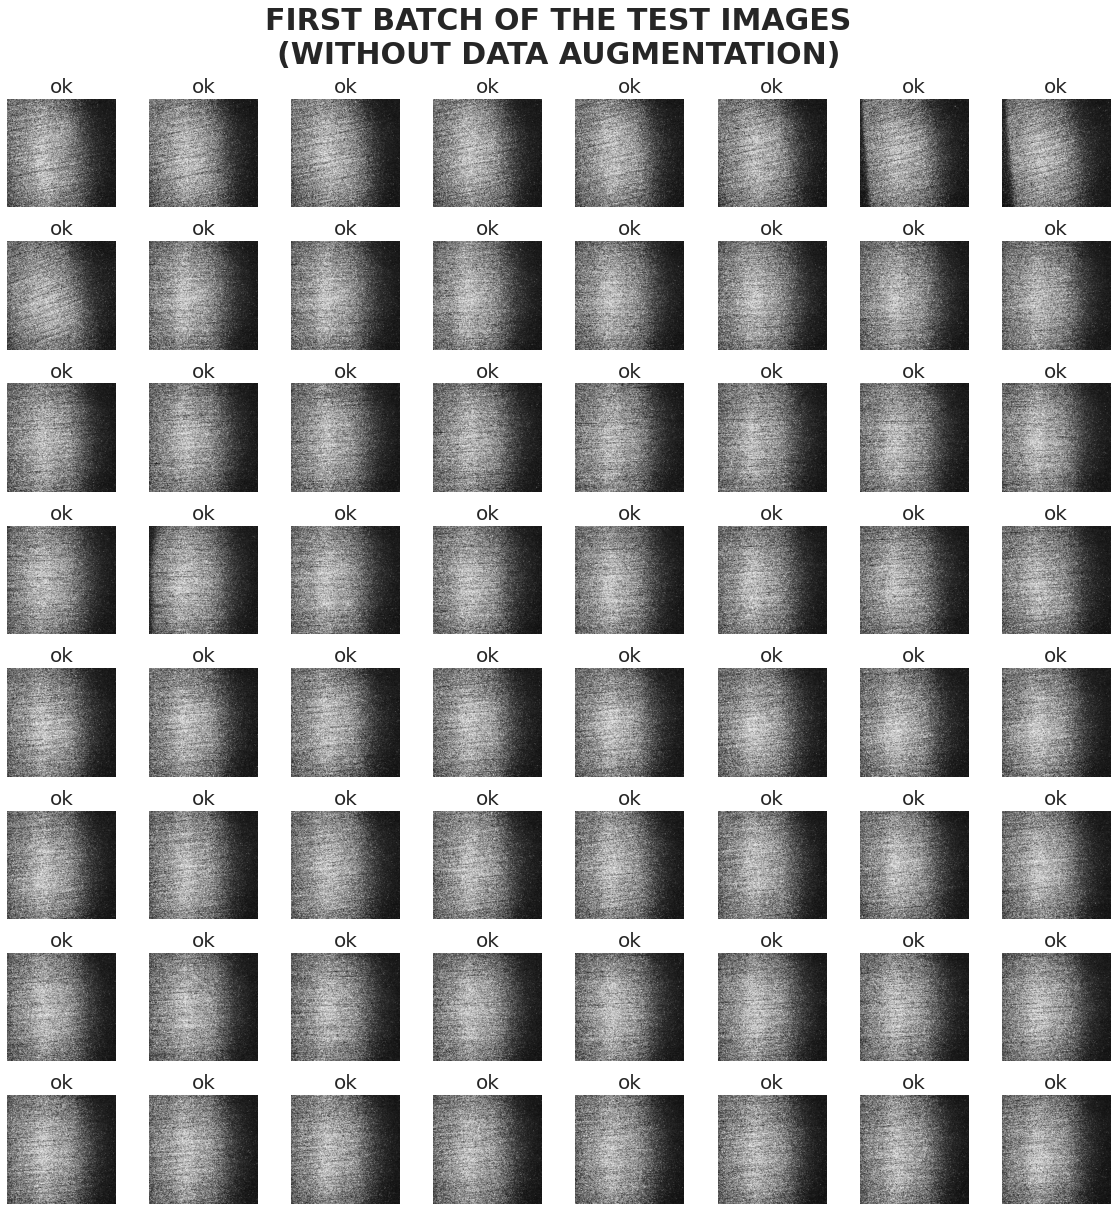

In [ ]:
test_images = visualizeImageBatch(test_dataset,
                                  "FIRST BATCH OF THE TEST IMAGES\n(WITHOUT DATA AUGMENTATION)")

### Visualize Detailed Image
Let's also take a look on the detailed image by each pixel. Instead of plotting 300 pixels by 300 pixels (which computationally expensive), we take a small part of 25 pixels by 25 pixels only

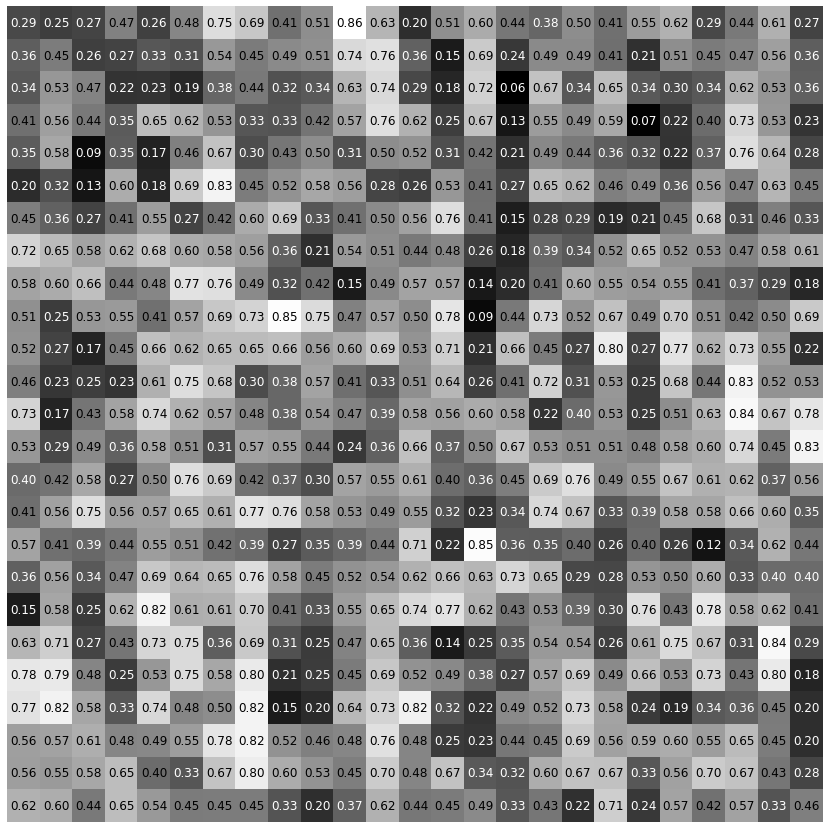

In [ ]:
img = np.squeeze(train_images[4])[75:100, 75:100]

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
ax.imshow(img, cmap = "gray")
ax.axis("off")

w, h = img.shape
for x in range(w):
    for y in range(h):
        value = img[x][y]
        ax.annotate("{:.2f}".format(value), xy = (y,x),
                    horizontalalignment = "center",
                    verticalalignment = "center",
                    color = "white" if value < 0.4 else "black")

These are the example of values that we are going to feed into our CNN architecture.

## Training the Network

As mentioned earlier, we are going to train a CNN model to classify the casting product image. CNN is used as an automatic feature extractor from the images so that it can learn how to distinguish between `bad` and `ok` casted products. It effectively uses the adjacent pixel to downsample the image and then use a prediction (fully-connected) layer to solve the classification problem. This is a simple illustration by [Udacity](https://github.com/udacity/deep-learning-v2-pytorch) on how the layers are arranged sequentially:

![](https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/convolutional-neural-networks/conv-visualization/notebook_ims/CNN_all_layers.png)

### Define Architecture

Here is the detailed architecture that we are going to use:

1. **First convolutional layer**: consists of 32 filters with kernel_size matrix 3 by 3. Using 2-pixel strides at a time, reduce the image size by half.
2. **First pooling layer**: Using max-pooling matrix 2 by 2 (pool_size) and 2-pixel strides at a time further reduce the image size by half.
3. **Second convolutional layer**: Just like the first convolutional layer but with 16 filters only.
4. **Second pooling layer**: Same as the first pooling layer.
5. **Flattening**: Convert two-dimensional pixel values into one dimension, so that it is ready to be fed into the fully-connected layer.
6. **First dense layer + Dropout**: consists of 128 units and 1 bias unit. Dropout of rate 20% is used to prevent overfitting.
7. **Second dense layer + Dropout**: consists of 64 units and 1 bias unit. Dropout of rate 20% is also used to prevent overfitting.
8. **Output layer**: consists of only one unit and activation is a sigmoid function to convert the scores into a probability of an image being bad.

For every layer except output layer, we use Rectified Linear Unit (ReLU) activation function.

![relu](https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/convolutional-neural-networks/conv-visualization/notebook_ims/relu_ex.png)



In [ ]:
model_cnn = Sequential(
    [
        # First convolutional layer
        Conv2D(filters = 32,
               kernel_size = 3,
               strides = 2,
               activation = "relu",
               input_shape = IMAGE_SIZE + (1, )),
        
        # First pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Second convolutional layer
        Conv2D(filters = 16,
               kernel_size = 3,
               strides = 2,
               activation = "relu"),
        
        # Second pooling layer
        MaxPooling2D(pool_size = 2,
                     strides = 2),
        
        # Flattening
        Flatten(),
        
        # Fully-connected layer
        Dense(128, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(64, activation = "relu"),
        Dropout(rate = 0.2),
        
        Dense(1, activation = "sigmoid")
    ]
)

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 149, 149, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 36, 16)        4624      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 18, 18, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5184)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

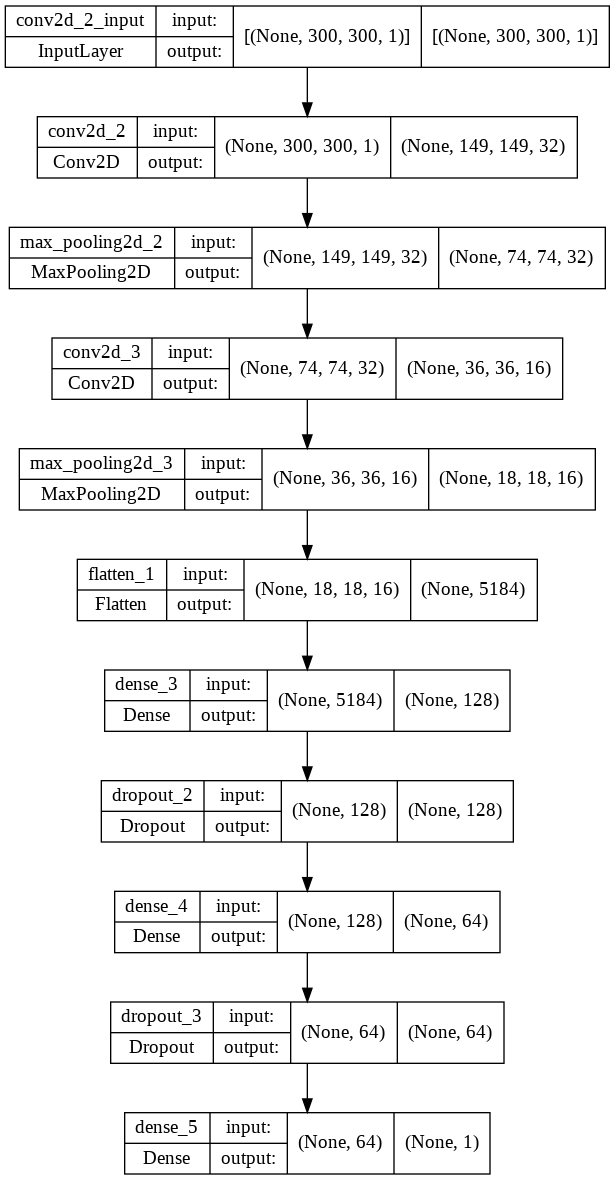

In [ ]:
keras.utils.plot_model(model_cnn, "card_model.png", show_shapes=True)  

### Compile the Model

Next, we specify how the model backpropagates or update the weights after each batch feed-forward. We use `adam` optimizer and a loss function `binary cross-entropy` since we are dealing with binary classification problem. The metrics used to monitor the training progress is accuracy.

In [ ]:
model_cnn.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

## Model Fitting¶
Before we do model fitting, let's check whether GPU is available or not.

In [ ]:
checkpoint = ModelCheckpoint('model/card_quality_inspection_cnn_model.hdf5',
                             verbose = 1,
                             save_best_only = True,
                             monitor='val_loss',
                             mode='min')

model_cnn.fit(train_dataset,
                    validation_data = validation_dataset,
                    batch_size = 16, 
                    epochs = 20,
                    callbacks = [checkpoint],
                    verbose = 1)

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 0.6993 - accuracy: 0.5151
Epoch 1: val_loss improved from inf to 0.68911, saving model to model/card_quality_inspection_cnn_model.hdf5
10/10 [==============================] - 9s 831ms/step - loss: 0.6993 - accuracy: 0.5151 - val_loss: 0.6891 - val_accuracy: 0.5068
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.4832
Epoch 2: val_loss did not improve from 0.68911
10/10 [==============================] - 7s 750ms/step - loss: 0.6941 - accuracy: 0.4832 - val_loss: 0.6936 - val_accuracy: 0.4932
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5336
Epoch 3: val_loss improved from 0.68911 to 0.68580, saving model to model/card_quality_inspection_cnn_model.hdf5
10/10 [==============================] - 7s 754ms/step - loss: 0.6918 - accuracy: 0.5336 - val_loss: 0.6858 - val_accuracy: 0.5068
Epoch 4/20
10/10 [==============================] - ETA:

### Training Evaluation
Let's plot both loss and accuracy metrics for train and validation data based on each epoch.

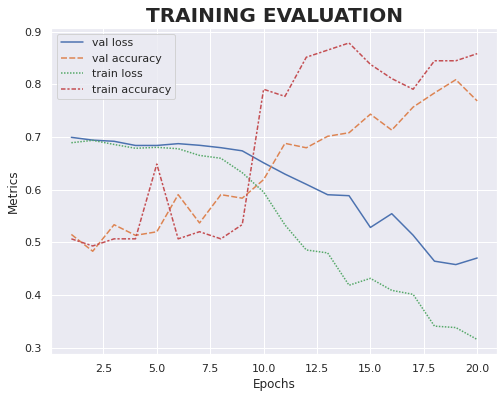

In [ ]:
plt.subplots(figsize = (8, 6))
sns.lineplot(data = pd.DataFrame(model_cnn.history.history,
                                 index = range(1, 1+len(model_cnn.history.epoch))))
plt.title("TRAINING EVALUATION", fontweight = "bold", fontsize = 20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")

plt.legend(labels = ['val loss', 'val accuracy', 'train loss', 'train accuracy'])
plt.show()

We can conclude that the model is **overfitting** the data since both train loss and val loss simultaneously dropped towards zero. Also, both train accuracy and val accuracy increase towards 100%.

### Testing on Unseen Images

Our model performs very well on the training and validation dataset which uses augmented images. Now, we test our model performance with unseen and unaugmented images.

In [ ]:
best_model = load_model("model/card_quality_inspection_cnn_model.hdf5")

In [ ]:
y_pred_prob = best_model.predict(test_dataset)

The output of the prediction is in the form of probability. We use THRESHOLD = 0.5 to separate the classes. If the probability is greater or equal to the THRESHOLD, then it will be classified as bad, otherwise ok.

In [ ]:
THRESHOLD = 0.5
y_pred_class = (y_pred_prob >= THRESHOLD).reshape(-1,)
y_true_class = test_dataset.classes[test_dataset.index_array]

pd.DataFrame(
    confusion_matrix(y_true_class, y_pred_class),
    index = [["Actual", "Actual"], ["ok", "bad"]],
    columns = [["Predicted", "Predicted"], ["ok", "bad"]],
)


Predicted    
                  ok bad
Actual ok         94   1
       bad         0  91

In [ ]:
print(classification_report(y_true_class, y_pred_class, digits = 4))

              precision    recall  f1-score   support

           0     1.0000    0.9895    0.9947        95
           1     0.9891    1.0000    0.9945        91

    accuracy                         0.9946       186
   macro avg     0.9946    0.9947    0.9946       186
weighted avg     0.9947    0.9946    0.9946       186



According to the problem statement, we want to minimize the case of False Negative, where the bad part is misclassified as `ok`. This can cause the whole order to be rejected and create a big loss for the company. Therefore, in this case, we prioritize Recall over Precision.

But if we take into account the cost of re-plating a product, we have to minimize the case of False Positive also, where the ok product is misclassified as `bad`. Therefore we can prioritize the `F1 score` which combines both Recall and Precision.

On test dataset, the model achieves a very good result as follow:

- Accuracy: 99.46%
- Recall: 98.95%
- Precision: 98.91%
- F1 score: 99.46%

___

# Conclusion
By using CNN and on-the-fly data augmentation, the performance of our model in training, validation, and test images is almost perfect, reaching 99.46% accuracy and F1 score. We can utilize this model by embedding it into a surveillance camera where the system can automatically separate bad product from the production line. This method surely can reduce human error and human resources on manual inspection, but it still needs supervision from human since the model is not 100% correct at all times.